# Analyzing playlists

Jupyter notebook analyzing playlist data. 

Written by Bryce Frentz  
03/04/2020

In [1]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

import pprint
pp = pprint.PrettyPrinter()
import os

import pandas as pd
import numpy as np
import datetime
from math import pi, ceil

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

datapath = './data/'

In [ ]:
def showTracks:

In [2]:
# Get access
client_id = os.getenv('SPOTIPY_CLIENT_ID')
secret = os.getenv('SPOTIPY_CLIENT_SECRET')
username = '128455376'
userURI = 'spotify:user:128455376'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Get read access to your library
scope = 'user-library-read'
token = util.prompt_for_user_token(username, scope)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print('Can\'t get token for ' + username + '.')



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=c4b6c7bc4fa446d28e72d59ff2d1172d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888&scope=user-library-read in your browser




Enter the URL you were redirected to:  http://localhost:8888/lab/workspaces/auto-S?code=AQB_3COjqcx8r_1-_LDcsm88u2sHm0hupYFw0WMK8B7HEkkwHdvh5SmZcTFuxeRsRAnxQw3AEAx4YKP22jSWyFICacjj0D187_PbfGgA8fH0PRMaaOVsLei5mesCJTAEsPiw9qeAQCsuDVZjN6ffvCqird3Mo-pu0KpfSgmrnSn0Ujh0MD2r2lyJGu9K4GnEXFQx2TW71HXU0DcC7r4


In [4]:
df_savedTracks = pd.DataFrame()
trackList = ''
addedTimeList = []
artistList = []
titleList = []

moreSongs = True
offsetIndex = 0

while moreSongs:
    songs = sp.current_user_saved_tracks(offset=offsetIndex)
    
    for song in songs['items']:
        # join track ids to a string for the audio features function
        trackList += song['track']['id'] + ','
        
        # Get the time that the song was added
        addedTimeList.append(song['added_at'])
        
        # get the title of the song
        titleList.append(song['track']['name'])
        
        # Get all the artists in the song
        artists = song['track']['artists']
        artistsName = ''
        for artist in artists:
            artistsName += artist['name'] + ','
        
        artistList.append(artistsName[:-1])
            
        
    # Get the track features and append into the dataframe
    trackFeatures = sp.audio_features(trackList[:-1])
    df_temp = pd.DataFrame(trackFeatures)
    df_savedTracks = df_savedTracks.append(df_temp)
    
    trackList = ''
    
    if songs['next'] == None:
        # No more songs in playlist
        moreSongs = False
    else:
        # Get the next n songs
        offsetIndex += songs['limit']
        
# include the timestamp added, title, and artist of a songs
df_savedTracks['added_at'] = addedTimeList
df_savedTracks['song_title'] = titleList
df_savedTracks['artists'] = artistList

In [7]:
#convert to datetime, extrated year and month from added_at
df_savedTracks['added_at'] = pd.to_datetime(df_savedTracks['added_at'])
df_savedTracks['added_year'] = df_savedTracks['added_at'].apply(lambda x : x.year)
df_savedTracks['added_month'] = df_savedTracks['added_at'].apply(lambda x : x.month)

df_savedTracks['normalizedTempo'] = (df_savedTracks['tempo'] / df_savedTracks['tempo'].max())

In [9]:
df_savedTracks.tail()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,...,track_href,type,uri,valence,added_at,song_title,artists,added_year,added_month,normalizedTempo
2,0.00043,https://api.spotify.com/v1/audio-analysis/2fmC...,0.490,196520,0.848,2fmCA13dwQQOGBIbIOWRiJ,0.000008,9,0.0665,-5.050,...,https://api.spotify.com/v1/tracks/2fmCA13dwQQO...,audio_features,spotify:track:2fmCA13dwQQOGBIbIOWRiJ,0.6980,2016-08-15 04:32:52,LA Devotee,Panic! At The Disco,2016,8,0.888596
3,0.00329,https://api.spotify.com/v1/audio-analysis/3fwK...,0.556,254320,0.708,3fwKVZ73y7UUGMyR6rVCRa,0.000000,7,0.3290,-5.708,...,https://api.spotify.com/v1/tracks/3fwKVZ73y7UU...,audio_features,spotify:track:3fwKVZ73y7UUGMyR6rVCRa,0.2060,2016-08-15 04:32:52,Golden Days,Panic! At The Disco,2016,8,0.646289
4,0.00191,https://api.spotify.com/v1/audio-analysis/5eoZ...,0.531,171520,0.825,5eoZTdiq4C4aoEfUwAN0ha,0.000000,7,0.3290,-5.333,...,https://api.spotify.com/v1/tracks/5eoZTdiq4C4a...,audio_features,spotify:track:5eoZTdiq4C4aoEfUwAN0ha,0.8240,2016-08-15 04:32:52,"The Good, the Bad and the Dirty",Panic! At The Disco,2016,8,0.787987
5,0.47400,https://api.spotify.com/v1/audio-analysis/5j9y...,0.174,202547,0.337,5j9yOfRB2s6OMS1YwwYiMw,0.000294,10,0.1100,-8.767,...,https://api.spotify.com/v1/tracks/5j9yOfRB2s6O...,audio_features,spotify:track:5j9yOfRB2s6OMS1YwwYiMw,0.0978,2016-08-15 04:32:52,Impossible Year,Panic! At The Disco,2016,8,0.432054
6,0.00205,https://api.spotify.com/v1/audio-analysis/6od5...,0.570,178600,0.865,6od5hFv9IT5JHc7NEF9HRv,0.000000,8,0.4040,-4.518,...,https://api.spotify.com/v1/tracks/6od5hFv9IT5J...,audio_features,spotify:track:6od5hFv9IT5JHc7NEF9HRv,0.6910,2016-08-02 21:25:24,Victorious,Panic! At The Disco,2016,8,0.555429


## Description of features from Spotify developer website

* acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<p/>
* danceability - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<p/>
* energy - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<p/>
* instrumentalness - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<p/>
* liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<p/>
* loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
<p/>
* speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<p/>
* valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
<p/>
* Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
<p/>
* popularity - A numerical score between 0 and 100 representative of the popularity of a given track. 

## Changes in preference over time

In [10]:
# Filter data to songs added after 2014 and before 2019
df_group = df_savedTracks.groupby(['added_year','added_month']).mean().reset_index()
df_group['added_at'] = df_group.apply(lambda row: datetime.date(int(row['added_year']), int(row['added_month']), 1), axis=1)
df_group.head()

,added_year,added_month,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,normalizedTempo,added_at
0,2016,8,0.052752,0.498800,196810.800000,0.762300,0.000030,6.5,0.20774,-5.372500,0.700000,0.05562,126.318100,3.9,0.52838,0.637767,2016-08-01
1,2016,9,0.005790,0.494000,229093.000000,0.841000,0.000000,7.0,0.12200,-4.784000,1.000000,0.08380,162.013000,4.0,0.56700,0.817987,2016-09-01
2,2017,6,0.076150,0.606833,212124.666667,0.789333,0.003119,5.0,0.18555,-6.593167,0.833333,0.04445,127.290833,4.0,0.55400,0.642679,2017-06-01
3,2017,7,0.098400,0.621000,256133.000000,0.481000,0.000000,11.0,0.24100,-8.016000,1.000000,0.03710,65.004000,4.0,0.67900,0.328199,2017-07-01
4,2017,9,0.869000,0.255000,435760.000000,0.079600,0.704000,9.0,0.11100,-26.580000,0.000000,0.04430,121.667000,4.0,0.07820,0.614284,2017-09-01


<Figure size 2160x1440 with 0 Axes>

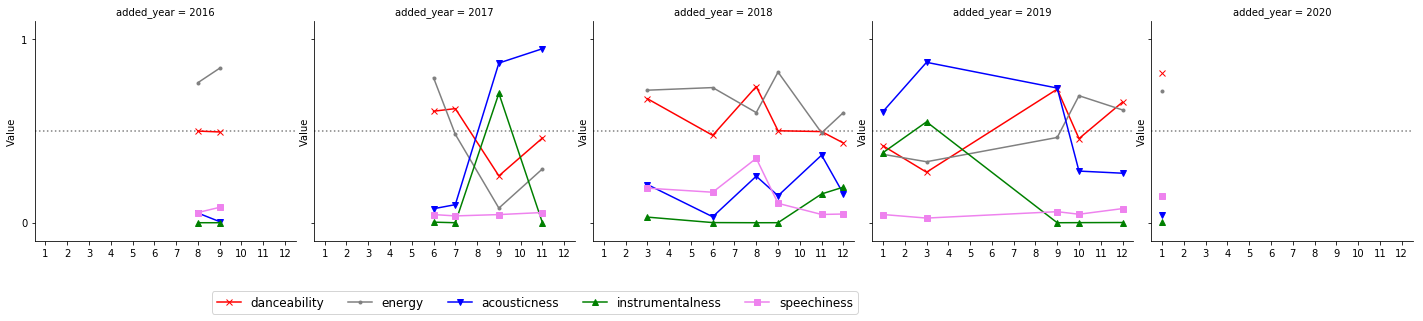

In [11]:
# sns.set(style="ticks")
plt.figure(figsize=(30,20))
grid = sns.FacetGrid(data=df_group, col="added_year", height=4)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0.5, ls=":", c=".5")

# Draw a line plot to show the average value per month
grid.map(plt.plot, "added_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "added_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "added_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "added_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "added_month", "speechiness", marker="s", color='violet', label='speechiness')

# Adjust the tick positions and labels
grid.set(xticks=np.arange(13), yticks=[0, 1], xlim=(0.5,12.5), ylim=(-0.1,1.1), ylabel='Value', xlabel='')

# Adjust legend
plt.legend(loc='best', bbox_to_anchor=(-1.1, -0.2), ncol=5, fontsize=12)


plt.show()

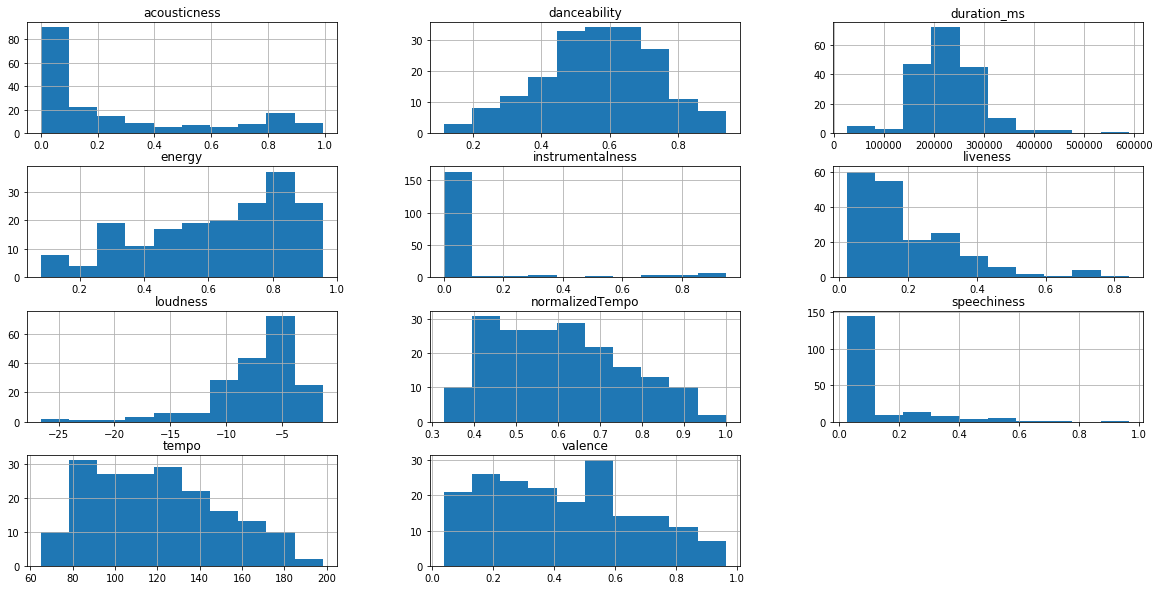

In [15]:
# feature breakdown
df_savedTracks[['acousticness', 'danceability', 'instrumentalness', 
           'energy', 'speechiness','tempo','valence','duration_ms',
           'liveness', 'loudness', 'normalizedTempo']].hist(figsize=(20,10))
plt.show()

## Clustering similar songs

In [16]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']
df_cluster = df_savedTracks[cluster_features]

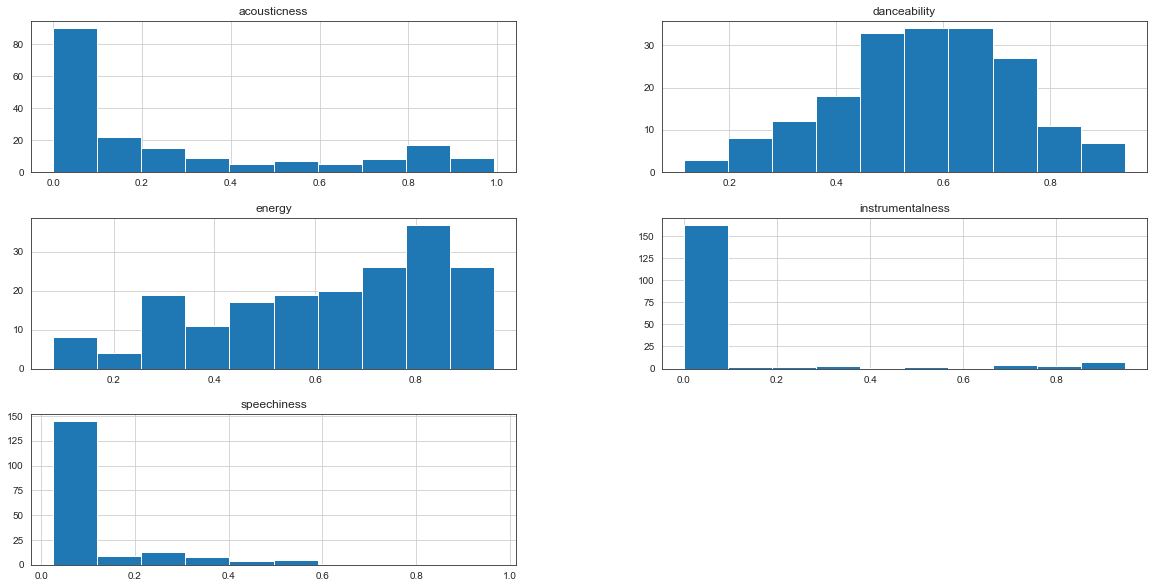

In [18]:
#plt.figure(figsize=(20,15))
#
#sns.set_style('white')
#fig, axes = plt.subplots(1,5, figsize=(20,5))
#for i, feature in enumerate(cluster_features):
#    sns.distplot(df_cluster[feature], ax=axes[i], bins=20, kde=False)
#
#sns.despine()
#plt.show()

df_cluster.hist(figsize=(20,10))
plt.show()

In [19]:
# The idea behind StandardScaler is that it will transform your data 
# such that its distribution will have a mean value 0 and standard deviation of 1.

X = np.array(df_cluster)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

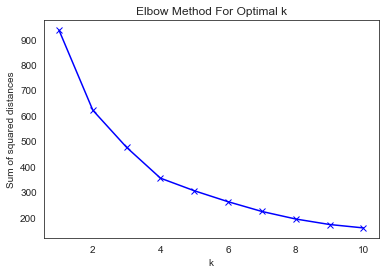

In [21]:
# Elbow method for determining number of clusters for kmeans clustering
ss_dist = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=10000, init='k-means++', random_state=123)
    km = km.fit(X)
    ss_dist.append(km.inertia_)
    
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()    # looks like 4 clusters

In [22]:
num_clusters = 5
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=123).fit(X)

## Using Principal Component Anlysis (PCA) for dimension reduction of data

Dimension reduction aims to make a low dimensional set of features from a higher dimension while preserving as much information as possible. 

In [23]:
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(X)

In [24]:
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.8497567903694936


array([0.45009908, 0.70375505, 0.84975679])

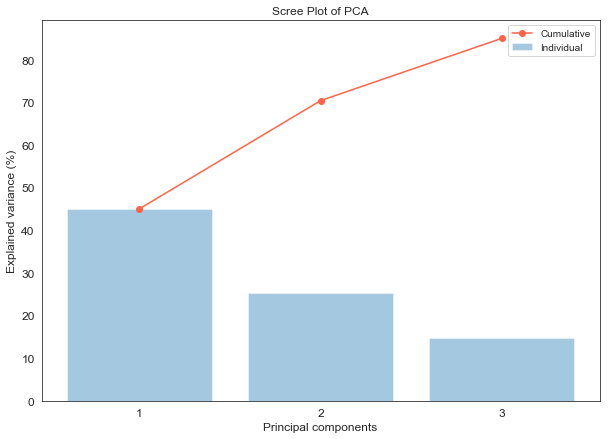

In [26]:
df_scree = pd.DataFrame({'Component': ['1','2','3'],'Indiv':pca.explained_variance_ratio_})
df_scree['cum_sum'] = df_scree['Indiv'].cumsum()
df_scree

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Scree Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

The blue bar shows how much information each principal component (PC) contributes to the data. The first PC contributes 40% of information about the data. The second and third contributes 20% each. The red line shows the cumulative information of the data by the PCs. By reducing from 5 dimensions to 2, 60% information of the data is preserved. Likewise if we were to reduce to 3 dimensions, 80% information of the data is preserved.

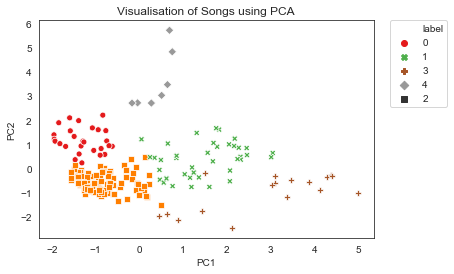

In [27]:
#Plot lower dimensions
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca['label'] = kmeanModel.labels_

sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA')
plt.show()

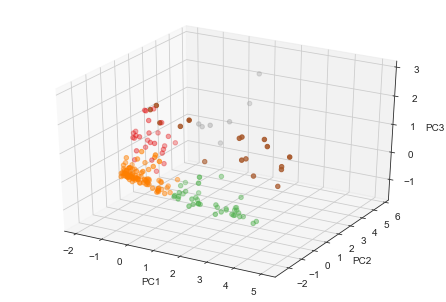

In [28]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

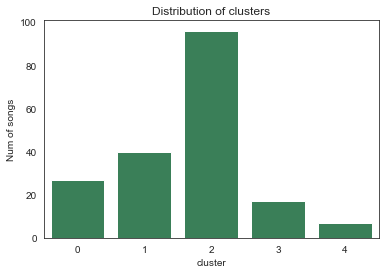

In [30]:
# assign label to recent dataframe
df_savedTracks.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = df_savedTracks.groupby('cluster').size().reset_index(name='Num of songs')
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show()

## Characteristics of the clusters:

No handles with labels found to put in legend.


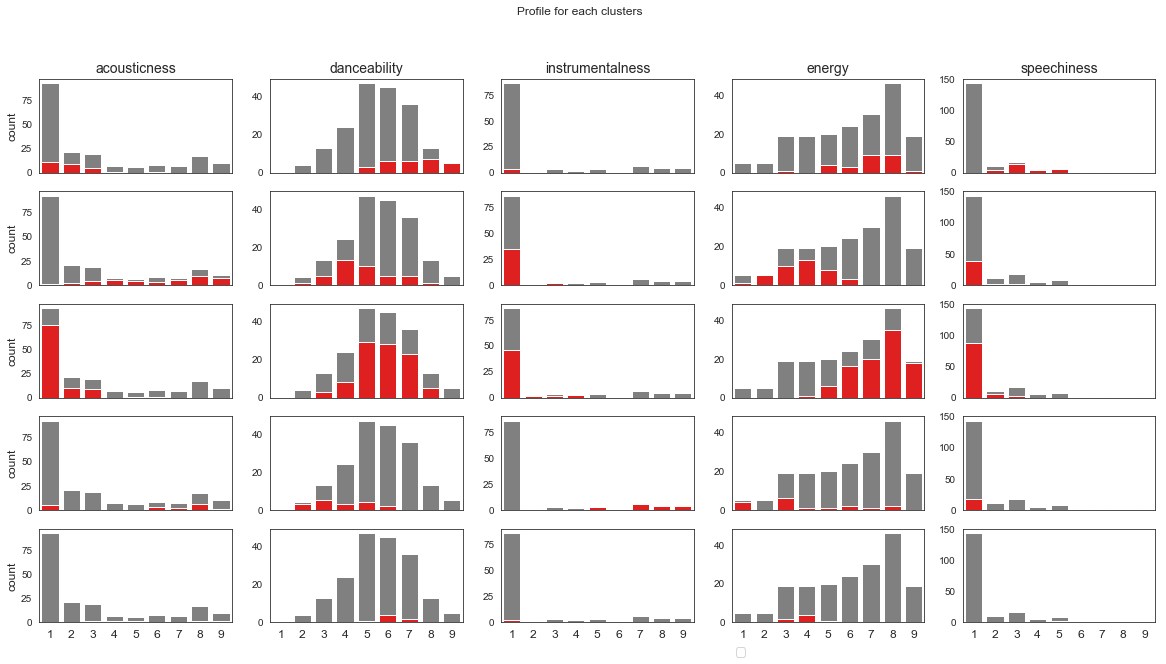

In [32]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(df_savedTracks['cluster'].unique()):
    #filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = df_savedTracks[df_savedTracks['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features:
        #create binned count for all saved df and clustered df
        saved_grp = df_savedTracks.groupby(pd.cut(df_savedTracks[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
        # plot overall distribution and cluster distribution on the ax
        sns.barplot(data=saved_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
        # configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    

plt.legend(loc='best', bbox_to_anchor=(-1.1, -0.2), ncol=5, fontsize=12)
plt.show()

Each Row represents the cluster, 0 to 4, and the each Column represents the feature. The grey bar represents the distribution of the feature. This allows us to get a rough idea of the distribution of the feature. The red bar represents the distribution of the feature in that cluster which is used to compare against the other clusters.
When we look at the distribution of each cluster we can see that each cluster is high or low in certain features. This is identified by whether the red bar is on the right(high) or left(low) with respect to the grey bar. From these characteristics we can profile them and even come up with a cluster identity.

## Examine features with radar charts

In [33]:
# calculating the mean of the variables to get an 'average song' for a cluster
radar_col = cluster_features + ['cluster']

# feature average for each cluster as a radar chart
df_radar = df_savedTracks[radar_col]
df_radar = df_radar.groupby('cluster').mean().reset_index()

In [34]:
# radar plot example https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

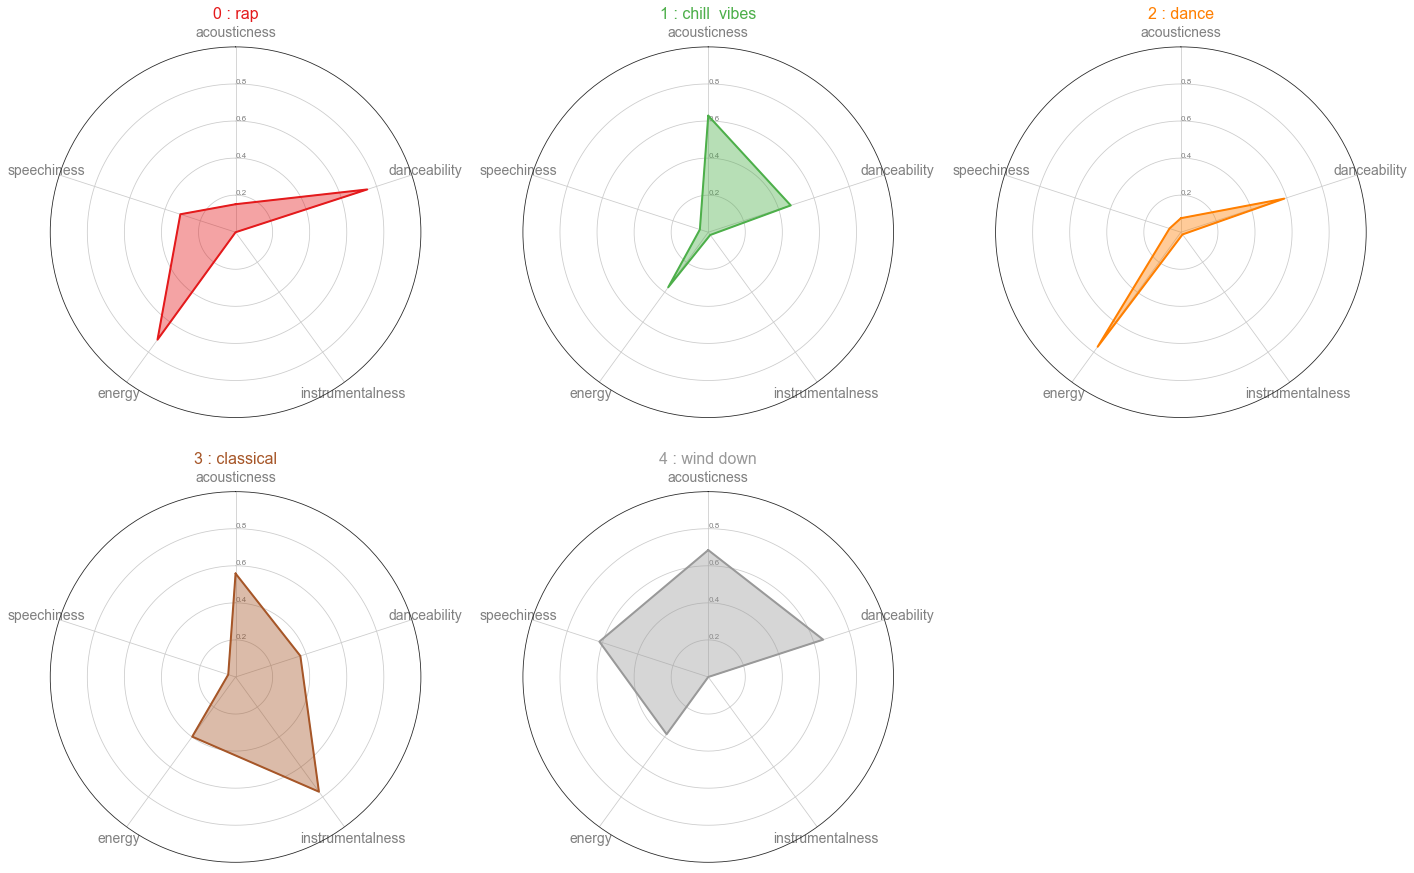

In [35]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))

# Create cluster name
title_list = ['rap', 'chill  vibes', 'dance', 'classical', 'wind down']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

    
# Show plot
plt.show()

## Major vs minor

No handles with labels found to put in legend.


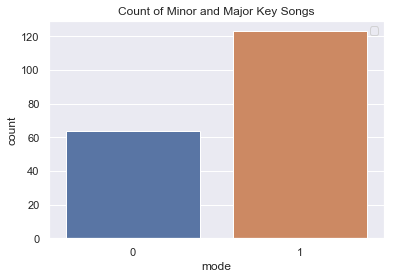

In [42]:
sns.set(style="darkgrid")
sns.countplot(data=df_savedTracks, x='mode')
plt.title('Count of Minor and Major Key Songs')
plt.legend()
plt.show()